# Amplification Factor Comparison

We consider the heat equation given by $$\partial_tq - \alpha\partial^2_{xx}q = 0$$.
Assuming a solution of the form $q(x,t) = \phi(t)e^{ikx}$, using the second order central finite difference approximation for the second derivative, we get

$$
\frac{d \phi (t)}{dt} = -\frac{2 \alpha}{\Delta x^2}[1 - \cos(k \Delta x)] \phi
$$

Applying the Backwards Euler scheme, we get

$$
\phi^{n+1} = \frac{1}{1+\alpha\Delta t k'}\phi^n
$$

where $k' = \frac{2}{\Delta x^2}[1 - \cos(k \Delta x)]$.

We note that the max value of $k'$ occurs when $\cos(k\Delta x) = -1$, min value occurs when $\cos(k\Delta x) = 1$. Hence we can bound the amplification factor as follows:

$$
\frac{1}{1 + \alpha \Delta t \frac{4}{\Delta x^2}} \leq G \leq 1
$$
We compare this to the numerical result.

In [2]:
from math import pi
nt = 256
nx = 128

# initialise our spatial and time discretisations
lx = 2*pi
dx = lx/nx

theta = 1

alpha = 1
dt = 0.01

In [14]:
import numpy as np
def k_prime(k):
    return 2/dx**2 * (1- np.cos(k*dx))

def G(k):
    return 1/(1 + alpha*dt*k_prime(k))

In [15]:
upper = G(1)
print(upper)

0.9901009781579017


The domain is $x\in[-l_{x}/2, l_{x}/2]$ and will be discretised by `nx` equally spaced grid points.

In [16]:
import numpy as np

mesh = np.linspace(start=-lx/2, stop=lx/2, num=nx, endpoint=False)

We use the ``gradient_stencil`` and ``sparse_circulant`` functions from the ``serial.ipynb`` notebook for the advection equation.

In [17]:
from scipy import sparse

# Finite difference spatial discretisations                                                                                                                                                   
def gradient_stencil(grad, order):                                                                                                                                                            
    '''                                                                                                                                                                                       
    Return the centred stencil for the `grad`-th gradient                                                                                                                                     
    of order of accuracy `order`                                                                                                                                                              
    '''                                                                                                                                                                                       
    return {                                                                                                                                                                                  
        1: {  # first gradient                                                                                                                                                                
            2: np.array([-1/2, 0, 1/2]),                                                                                                                                                      
            4: np.array([1/12, -2/3, 0, 2/3, -1/12]),                                                                                                                                         
            6: np.array([-1/60, 3/20, -3/4, 0, 3/4, -3/20, 1/60])                                                                                                                             
        },                                                                                                                                                                                    
        2: {  # second gradient                                                                                                                                                               
            2: np.array([1, -2, 1]),                                                                                                                                                          
            4: np.array([-1/12, 4/3, -5/2, 4/3, -1/12]),                                                                                                                                      
            6: np.array([1/90, -3/20, 3/2, -49/18, 3/2, -3/20, 1/90])                                                                                                                         
        },                                                                                                                                                                                    
        4: {  # fourth gradient                                                                                                                                                               
            2: np.array([1,  -4, 6, -4, 1]),                                                                                                                                                  
            4: np.array([-1/6, 2, -13/2, 28/3, -13/2, 2, -1/6]),                                                                                                                              
            6: np.array([7/240, -2/5, 169/60, -122/15, 91/8, -122/15, 169/60, -2/5, 7/240])  # noqa: E501                                                                                     
        }                                                                                                                                                                                     
    }[grad][order]                                                                                                                                                                            
                                                                                                                                                                                              
                                                                                                                                                                                              
def sparse_circulant(stencil, n):                                                                                                                                                             
    '''                                                                                                                                                                                       
    Return sparse scipy matrix from finite difference                                                                                                                                         
    stencil on a periodic grid of size n.                                                                                                                                                     
    '''                                                                                                                                                                                       
    if len(stencil) == 1:                                                                                                                                                                     
        return sparse.spdiags([stencil[0]*np.ones(n)], 0)                                                                                                                                     
                                                                                                                                                                                              
    # extend stencil to include periodic overlaps                                                                                                                                             
    ns = len(stencil)                                                                                                                                                                         
    noff = (ns-1)//2                                                                                                                                                                          
    pstencil = np.zeros(ns+2*noff)                                                                                                                                                            
                                                                                                                                                                                              
    pstencil[noff:-noff] = stencil                                                                                                                                                            
    pstencil[:noff] = stencil[noff+1:]                                                                                                                                                        
    pstencil[-noff:] = stencil[:noff]                                                                                                                                                         
                                                                                                                                                                                              
    # constant diagonals of stencil entries                                                                                                                                                   
    pdiags = np.tile(pstencil[:, np.newaxis], n)                                                                                                                                              
                                                                                                                                                                                              
    # offsets for inner domain and periodic overlaps                                                                                                                                          
    offsets = np.zeros_like(pstencil, dtype=int)                                                                                                                                              
                                                                                                                                                                                              
    offsets[:noff] = [-n+1+i for i in range(noff)]                                                                                                                                            
    offsets[noff:-noff] = [-noff+i for i in range(2*noff+1)]                                                                                                                                  
    offsets[-noff:] = [n-noff+i for i in range(noff)]                                                                                                                                         
                                                                                                                                                                                              
    return sparse.spdiags(pdiags, offsets)

In [18]:
# Mass matrix (identity)
M = sparse_circulant([1], nx)

# Diffusion matrix
L = sparse_circulant(gradient_stencil(2, order=2), nx)

In [19]:
from scipy.sparse import linalg as spla

# Spatial matrix
K = -(alpha/dx**2)*L    

#A0q^n + A1q^n+1 = 0
A0 = -M/dt + (1 - theta)*K                                                                                                                                                                    
A1 = M/dt + theta*K
A1.solve = spla.factorized(A1.tocsc())

We set up initial conditions and integrate ``nt`` timesteps.

In [55]:
qinit = np.zeros_like(mesh)                                                                                                                                                                   
qinit[:] = np.cos(mesh*128)
q = np.zeros((nt+1, len(qinit)))                                        
q[0] = qinit

for i in range(nt-1):                                                                                                                                                                         
    q[i+1] = A1.solve(-A0.dot(q[i]))

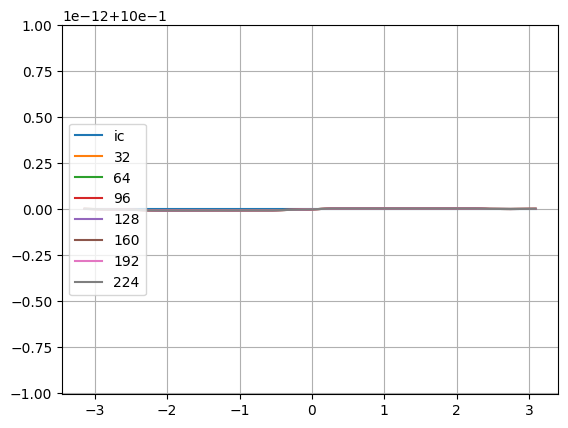

In [56]:
import matplotlib.pyplot as plt                                                                                                                                                           
nplot = 32
plt.plot(mesh, qinit, label='ic')                                                                                                                                                         
for i in range(nplot, nt, nplot):                                                                                                                                       
    plt.plot(mesh, q[i+1], label=str(i))                                                                                                                                                  
plt.legend(loc='center left')                                                                                                                                                             
plt.grid()

We estimate the amplification factor at timestep $i$ by the ratio of norms:
$$
\frac{\| q^{i+1} \|}{\| q^{i} \|}.
$$

In [57]:
amp_factors = []
for i in range(nt-1):
    amp = np.linalg.norm(q[i+1]) / np.linalg.norm(q[i])
    amp_factors.append(amp)

In [58]:
# Check upper bound and lower bounds hold

assert max(amp_factors) < 1
assert min(amp_factors) > 1/(1 + dt*alpha*(4/dx**2))

AssertionError: 

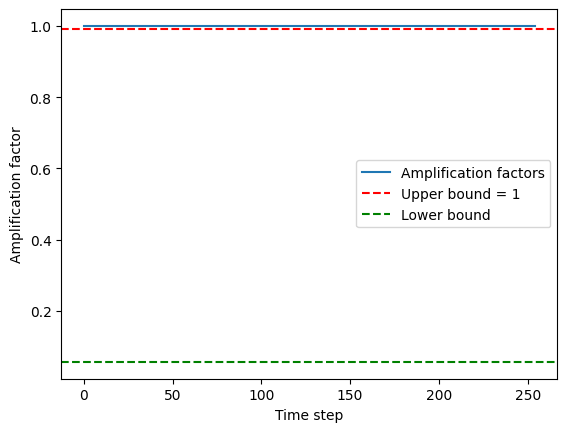

In [59]:
plt.plot(amp_factors, label='Amplification factors')
plt.axhline(upper, color='r', linestyle='--', label='Upper bound = 1')
plt.axhline(1/(1 + dt*alpha*(4/dx**2)), color='g', linestyle='--', label='Lower bound')

plt.xlabel('Time step')
plt.ylabel('Amplification factor')
plt.legend()
plt.show()

In [60]:
print(amp_factors)

[np.float64(1.0), np.float64(1.0), np.float64(0.9999999999999999), np.float64(1.0), np.float64(0.9999999999999997), np.float64(1.0), np.float64(1.0000000000000002), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(1.0), np.float64(0.9999999999999999), np.float64(1.0), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(1.0), np.float64(0.9999999999999999), np.float64(1.0), np.float64(0.9999999999999999), np.float64(1.0), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(1.0), np.float64(0.9999999999999999), np.float64(1.0), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(1.0), np.float64(1.0), np.float64(0.9999999999999997), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9999999999999999), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)

In [61]:
amp_factors[1] < upper

np.False_

We now analyse the behaviour of the amplification factor for different frequencies.

In [71]:
freqs = [2**i for i in range(-8, 8)]
print(freqs)
nx = 128
out = []
for freq in freqs:
    # rebuild mesh and operators for this nx
    mesh = np.linspace(start=-lx/2, stop=lx/2, num=nx, endpoint=False)
    dx = lx / nx
    M = sparse_circulant([1], nx)
    L = sparse_circulant(gradient_stencil(2, order=2), nx)
    K = -(alpha / dx**2) * L

    A0 = -M/dt + (1 - theta) * K
    A1 = M/dt + theta * K
    A1.solve = spla.factorized(A1.tocsc())

    # initial condition
    qinit = np.cos(mesh * freq)
    q = np.zeros((nt+1, nx))
    q[0] = qinit

    # time-stepping
    for i in range(nt-1):
        q[i+1] = A1.solve(-A0 @ q[i])

    # first-step amplification
    amp = np.linalg.norm(q[1]) / np.linalg.norm(q[0])
    out.append(amp)

    nx *= 2  # prepare for next run
    print("time")

out

[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
time
time
time
time
time
time
time
time
time
time
time
time
time
time
time
time


[np.float64(0.9999999999932037),
 np.float64(0.9999999998914386),
 np.float64(0.9999999982633347),
 np.float64(0.9999999721868585),
 np.float64(0.9999995531068823),
 np.float64(0.9999927286823409),
 np.float64(0.9998760659707077),
 np.float64(0.997704266194327),
 np.float64(0.9900990099214316),
 np.float64(0.9615384616075344),
 np.float64(0.8620689657176388),
 np.float64(0.6097560979528781),
 np.float64(0.28089887672151076),
 np.float64(0.08896797166416565),
 np.float64(0.023832221196028344),
 np.float64(0.006066488724506596)]

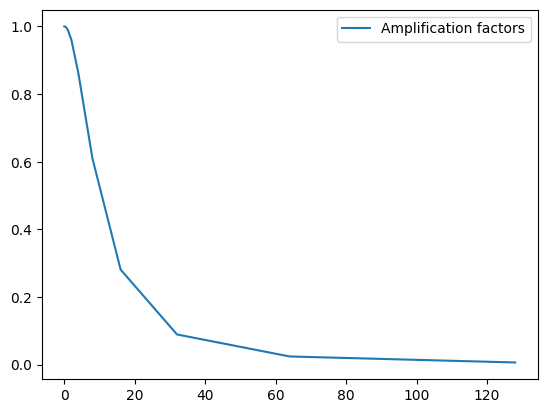

In [73]:
plt.plot(freqs, out, label='Amplification factors')
plt.legend()

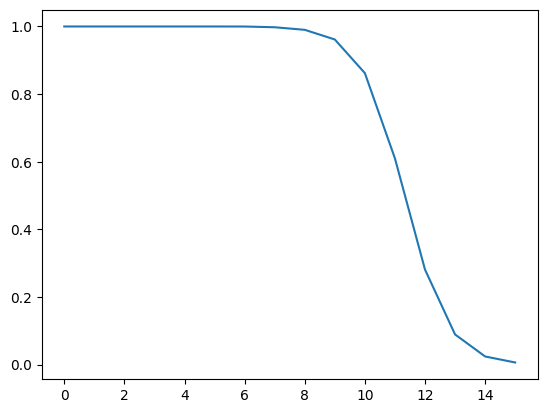

In [74]:
plt.plot(out)